In [124]:
# imports 
import pandas as pd
import nltk
import tensorflow as tf
import numpy as np 

# my files imports 
from utility.get_data import download_and_load_sts_data


In [125]:

sts_dev, sts_test = download_and_load_sts_data()
sts_test.head()

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


In [126]:
# This time it's better to use a pretrained model for word embeddings of dimension 300 to skip vocab thingy n all
'''
# Word2Vec
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')
word2vec_model.save('word2vec.bin')


# Glove
glove_model = api.load("glove-wiki-gigaword-300")
glove_model.save('glove_model.bin')

#Fasttext
fasttext_model = api.load('fasttext-wiki-news-subwords-300')
fasttext_model.save("fasttext.bin")

nltk.download('stopwords')
'''

'\n# Word2Vec\nimport gensim.downloader as api\nword2vec_model = api.load(\'word2vec-google-news-300\')\nword2vec_model.save(\'word2vec.bin\')\n\n\n# Glove\nglove_model = api.load("glove-wiki-gigaword-300")\nglove_model.save(\'glove_model.bin\')\n\n#Fasttext\nfasttext_model = api.load(\'fasttext-wiki-news-subwords-300\')\nfasttext_model.save("fasttext.bin")\n\nnltk.download(\'stopwords\')\n'

In [127]:
# I organize my data noww

from sklearn.model_selection import KFold
X = sts_dev[['sent_1','sent_1']]
X1 = sts_dev['sent_1']
X2 = sts_dev['sent_2']
y = sts_dev['sim']


X1test = sts_test['sent_1']
X2test = sts_test['sent_2']
ytest = sts_test['sim']

kf = KFold(n_splits=10, shuffle=True)
for train_index, val_index in kf.split(X):
    X1_train, X1_val = X1.iloc[train_index], X1.iloc[val_index]
    X2_train, X2_val = X2.iloc[train_index], X2.iloc[val_index]

    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [128]:
import re
from nltk.corpus import stopwords

import string

def remove_punctuation(text):
    new_text = ''.join(c for c in text if c not in string.punctuation)
    return new_text
def clean_text(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()
    
    remove_digits = str.maketrans('', '', '0123456789')
    text = text.translate(remove_digits)
    
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text
def remove_stopwords(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # Get the list of English stop words
    stop_words = set(stopwords.words('english'))
    # Remove the stop words from the list of words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Join the filtered words back into a single string
    return ' '.join(filtered_words)

In [129]:
X1_train = X1_train.apply(lambda x: remove_stopwords(remove_punctuation(clean_text(x))))
X2_train = X2_train.apply(lambda x: remove_stopwords(remove_punctuation(clean_text(x))))
X1test= X1test.apply(lambda x: remove_stopwords(remove_punctuation(clean_text(x))))
X2test = X2test.apply(lambda x: remove_stopwords(remove_punctuation(clean_text(x))))

In [130]:
'''from gensim.models import KeyedVectors, FastText
import numpy as np

def get_embedding(data, max_length=15):

    # Create an embedding layer
    embedding = []
    models = {
        'word2vec': KeyedVectors.load('word2vec.bin'),
        'glove': KeyedVectors.load('glove_model.bin'),
        'fasttext': KeyedVectors.load('fasttext.bin')
    }

    for sentence in data:
        # Split the sentence into words
        words = sentence.split()

        # Get the vector for each word
        vector = []
        for word in words:
            # Search for the word in all loaded models
            found = False
            for model_name, model in models.items():
                if word in model:
                    vector.append(model[word])
                    found = True
                    break

            # If the word is not found in any model, use FastText to embed it
            if not found:
                fasttext_model = FastText(sentences=data, vector_size=300)
                vector.append(fasttext_model.wv[word])

        embedding.append(vector)
    embedding_dim = 300
    # Convert the embedding list to a 3D tensor
    embedding_tensor = np.zeros((len(embedding), max_length, embedding_dim))
    for i, embed in enumerate(embedding):
        if len(embed) < max_length:
            # pad with zeros
            embedding_tensor[i, :len(embed), :] = embed
        else:
            # truncate
            embedding_tensor[i, :, :] = embed[:max_length]
    
    return embedding_tensor
    '''

"from gensim.models import KeyedVectors, FastText\nimport numpy as np\n\ndef get_embedding(data, max_length=15):\n\n    # Create an embedding layer\n    embedding = []\n    models = {\n        'word2vec': KeyedVectors.load('word2vec.bin'),\n        'glove': KeyedVectors.load('glove_model.bin'),\n        'fasttext': KeyedVectors.load('fasttext.bin')\n    }\n\n    for sentence in data:\n        # Split the sentence into words\n        words = sentence.split()\n\n        # Get the vector for each word\n        vector = []\n        for word in words:\n            # Search for the word in all loaded models\n            found = False\n            for model_name, model in models.items():\n                if word in model:\n                    vector.append(model[word])\n                    found = True\n                    break\n\n            # If the word is not found in any model, use FastText to embed it\n            if not found:\n                fasttext_model = FastText(sentences=data,

In [131]:
# Ww load the model onceeee
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
def get_sentence_embeddings(data, model = model):
    # Load the pre-trained model
    # Compute the sentence embeddings
    embeddings = model.encode(data)
    
    return embeddings

In [132]:
X1_train.reset_index(drop=True, inplace=True)
X2_train.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
X1_val.reset_index(drop=True, inplace=True)
X2_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X1test.reset_index(drop=True, inplace=True)
X2test.reset_index(drop=True, inplace=True)
ytest.reset_index(drop=True, inplace=True)

In [133]:
embedding1 = get_sentence_embeddings(X1_train)
embedding2 = get_sentence_embeddings(X2_train)


In [134]:
embedding1val = get_sentence_embeddings(X1_val)
embedding2val = get_sentence_embeddings(X2_val)


In [135]:
embedding1test = get_sentence_embeddings(X1test)
embedding2test = get_sentence_embeddings(X2test)

In [136]:
# We need to reshape our embeddings to 3D to put them in lstm shape will be (None = Batch size, timesteps = nb units = max-seq-len, input-dim = embedding_size)
embedding1 = embedding1.reshape((embedding1.shape[0], 1, embedding1.shape[1])) 
embedding2 = embedding2.reshape((embedding2.shape[0], 1, embedding2.shape[1])) 
embedding1val = embedding1val.reshape((embedding1val.shape[0], 1, embedding1val.shape[1])) 
embedding2val = embedding2val.reshape((embedding2val.shape[0], 1, embedding2val.shape[1])) 
embedding1test = embedding1test.reshape((embedding1test.shape[0], 1, embedding1test.shape[1])) 
embedding2test = embedding2test.reshape((embedding2test.shape[0], 1, embedding2test.shape[1])) 

In [147]:
#defining some params en pus des optimizers
hidden_units= 128
num_epochs= 5
batch_size = 64
embedding_dim = 768 
learning_rate = 1e-3

# Now i prepare optimizers with a clip to avoid exploading gradients 
from tensorflow.keras.optimizers import Adadelta, SGD, RMSprop, Adagrad, Adam, Adamax, Nadam

gradient_clipping_norm = 1.25

adadelta = Adadelta(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
sgd = SGD(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
rmsprop = RMSprop(clipnorm=gradient_clipping_norm, learning_rate = learning_rate)
adagrad = Adagrad(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
adam = Adam(clipnorm=gradient_clipping_norm, learning_rate = learning_rate)
adamax = Adamax(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)
nadam = Nadam(clipnorm=gradient_clipping_norm, learning_rate=learning_rate)

In [148]:
# define a list of hyperparameters to try because the first oenes were meh, i will do :
'''
- Do a search grid with a basic lstm to define optimal hyperparams
- Experiment with different architectures and loss functions 
- Perform some more data transformation 
- Use different loss functions
- Adding regularization
'''
hidden_units_list = [64, 128, 256]
batch_size_list = [32, 64, 128]
learning_rate_list = [1e-4, 1e-3, 1e-2]
optimizer_list = [Adadelta, SGD, RMSprop, Adagrad, Adam, Adamax, Nadam]

In [149]:
# Best model so far is Bidirectional gru with return sequences, adam optimizer and 64 bqtch size  

In [150]:
#from lstm import SiameseLSTMBase

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, LSTM, Bidirectional, GRU
from utility.distances import exponent_neg_manhattan_distance, exponent_neg_euclidean_distance
from keras.layers import Input, LSTM, Dense, concatenate



class LSTMBase(tf.keras.Model):

    def __init__(
        self, embedding_size, hidden_units, optimizer):
        
        super(LSTMBase, self).__init__()
        

        self.embedding_size = embedding_size
        self.hidden_units = hidden_units
        
        
        self.input_x1 = Input(shape=(None, self.embedding_size), name="input_x1")
        self.input_x2 = Input(shape=(None, self.embedding_size), name="input_x2")
        
    
        # create two LSTM layers, one for each input
        self.lstm_1 = Bidirectional(GRU(self.hidden_units, activation='relu'))(self.input_x1)
        self.lstm_2 = Bidirectional(GRU(self.hidden_units, activation='relu'))(self.input_x2)
        
        
        # concatenate the outputs of the two LSTM layers
        self.merged = concatenate([self.lstm_1, self.lstm_2])
        
        # add a Dense layer
        self.outt = Dense(1, activation='relu')(self.merged)
        
        # Definition of the model and compile it
        self.model = Model([self.input_x1, self.input_x2], [self.outt])
        self.optimizer = optimizer
        self.model.compile(loss='mean_squared_error', optimizer=self.optimizer)
        




In [154]:

''' #loop over all combinations of hyperparameters
for hidden_units in hidden_units_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rate_list:
            for optimizer in optimizer_list:
                # create a new model with the current hyperparameters
                siamese_lstm = LSTMBase(embedding_dim, hidden_units, optimizer(learning_rate=learning_rate))
                
                with tf.device('/gpu:0'):

                    history = siamese_lstm.model.fit(
                    x=[embedding1, embedding2],
                    y=y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=([embedding1val, embedding2val], y_val),
                    callbacks=callbacks
                )
                
                # evaluate the model
                mse = siamese_lstm.model.evaluate([embedding1test, embedding2test] ,ytest)
                
                # print the results
                print(f"hidden_units={hidden_units}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer.__name__}, mse={mse}")
                
                ###BEST MODEL : hidden_units=256, batch_size=128, learning_rate=0.001, optimizer=SGD, mse=2.478377103805542
                '''


Epoch 1/5
43/43 [==============================] - 5s 32ms/step - loss: 7.0424 - val_loss: 8.3228
Epoch 2/5
43/43 [==============================] - 1s 14ms/step - loss: 7.0288 - val_loss: 8.3101
Epoch 3/5
43/43 [==============================] - 1s 15ms/step - loss: 7.0152 - val_loss: 8.2972
Epoch 4/5
43/43 [==============================] - 1s 14ms/step - loss: 7.0013 - val_loss: 8.2844
Epoch 5/5
44/44 [==============================] - 0s 3ms/step - loss: 8.2391
hidden_units=64, batch_size=32, learning_rate=0.0001, optimizer=Adadelta, mse=8.239110946655273
Epoch 1/5
43/43 [==============================] - 4s 31ms/step - loss: 5.9060 - val_loss: 6.5349
Epoch 2/5
43/43 [==============================] - 1s 13ms/step - loss: 4.8372 - val_loss: 5.4550
Epoch 3/5
43/43 [==============================] - 1s 14ms/step - loss: 3.9895 - val_loss: 4.6535
Epoch 4/5
43/43 [==============================] - 1s 13ms/step - loss: 3.4059 - val_loss: 4.0844
Epoch 5/5
44/44 [=========================

In [140]:
siamese_lstm = LSTMBase(embedding_size = embedding_dim, hidden_units = hidden_units,optimizer=adam)


In [141]:
from keras.callbacks import CSVLogger, TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TerminateOnNaN

# train model
callbacks = [
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=20),
    CSVLogger('training.log'),
    TensorBoard(log_dir='./logs'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),  
    TerminateOnNaN(),
]


with tf.device('/gpu:0'):

    history = siamese_lstm.model.fit(
            x=[embedding1, embedding2],
            y=y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=([embedding1val, embedding2val], y_val),
            callbacks=callbacks
        )

Epoch 1/500
22/22 [==============================] - 4s 61ms/step - loss: 2.6593 - val_loss: 2.6201
Epoch 2/500
22/22 [==============================] - 0s 18ms/step - loss: 1.7421 - val_loss: 2.5419
Epoch 3/500
22/22 [==============================] - 0s 16ms/step - loss: 1.3657 - val_loss: 2.5955
Epoch 4/500
22/22 [==============================] - 0s 16ms/step - loss: 1.0469 - val_loss: 2.6941
Epoch 5/500
22/22 [==============================] - 0s 19ms/step - loss: 0.7572 - val_loss: 2.5273
Epoch 6/500
22/22 [==============================] - 0s 17ms/step - loss: 0.5521 - val_loss: 2.7409
Epoch 7/500
22/22 [==============================] - 0s 17ms/step - loss: 0.3467 - val_loss: 2.8685
Epoch 8/500
22/22 [==============================] - 0s 16ms/step - loss: 0.2478 - val_loss: 2.8061
Epoch 9/500
22/22 [==============================] - 0s 17ms/step - loss: 0.2489 - val_loss: 2.6995
Epoch 10/500
22/22 [==============================] - 0s 17ms/step - loss: 0.1805 - val_loss: 2.7624

In [142]:
# make a prediction using your trained Siamese LSTM model
predictions = siamese_lstm.model.predict([embedding1test, embedding2test])
print(f"Prediction: {predictions}")

Prediction: [[[0.85107136]]

 [[1.0938272 ]]

 [[0.32432368]]

 ...

 [[1.8825399 ]]

 [[2.676293  ]]

 [[1.5581056 ]]]


In [143]:
siamese_lstm.model.save("LSTMMODEL.h5")

In [145]:
# we change dimension to evaluate our model when return sequences is true

predictions_2d = predictions.mean(axis=1)
predictions_1d = predictions_2d.flatten()


In [146]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

predictions = predictions_1d

# Compute the mean squared error (MSE)
mse = mean_squared_error(ytest, predictions)
print(f"Mean squared error: {mse:.2f}")

# Compute the mean absolute error (MAE)
mae = mean_absolute_error(ytest, predictions)
print(f"Mean absolute error: {mae:.2f}")

# Compute the R-squared (R2) score
r2 = r2_score(ytest, predictions)
print(f"R-squared score: {r2:.2f}")

# Compute the explained variance score
evs = explained_variance_score(ytest, predictions)
print(f"Explained variance score: {evs:.2f}")

Mean squared error: 3.33
Mean absolute error: 1.44
R-squared score: -0.43
Explained variance score: -0.37


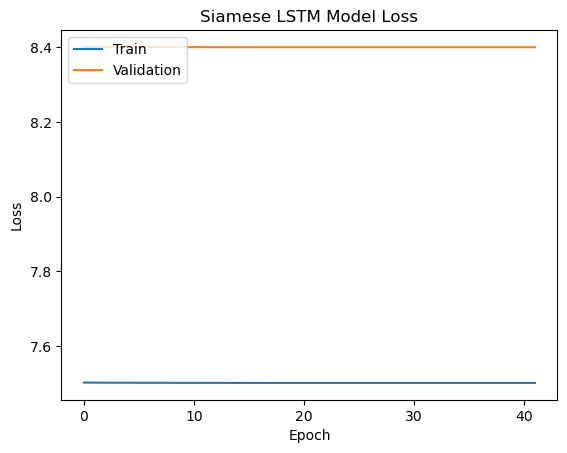

In [ ]:
import matplotlib.pyplot as plt


# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Siamese LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss_plot_lstm_siamese.png')
plt.show()


In [ ]:
Here are some code examples that demonstrate how you can implement the suggestions I mentioned earlier based on your code:

1. **Adjust the hyperparameters**:

```python
# define a list of hyperparameters to try
hidden_units_list = [64, 128, 256]
batch_size_list = [32, 64, 128]
learning_rate_list = [1e-4, 1e-3, 1e-2]
optimizer_list = [Adadelta, SGD, RMSprop, Adagrad, Adam, Adamax, Nadam]

# loop over all combinations of hyperparameters
for hidden_units in hidden_units_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rate_list:
            for optimizer in optimizer_list:
                # create a new model with the current hyperparameters
                model = LSTMBase(embedding_dim, hidden_units, optimizer(learning_rate=learning_rate))
                
                # train the model
                history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs)
                
                # evaluate the model
                mse = model.evaluate(x_test, y_test)
                
                # print the results
                print(f"hidden_units={hidden_units}, batch_size={batch_size}, learning_rate={learning_rate}, optimizer={optimizer.__name__}, mse={mse}")
```

2. **Change the model architecture**:

```python
class LSTMBase2(tf.keras.Model):
    def __init__(
        self, embedding_size, hidden_units, optimizer):
        super(LSTMBase2, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_units = hidden_units
        self.input_x1 = Input(shape=(None, self.embedding_size), name="input_x1")
        self.input_x2 = Input(shape=(None, self.embedding_size), name="input_x2")
        
        # create two LSTM layers with different activation functions
        self.lstm_1 = Bidirectional(LSTM(self.hidden_units, activation='tanh', return_sequences=True))(self.input_x1)
        self.lstm_2 = Bidirectional(LSTM(self.hidden_units, activation='sigmoid', return_sequences=True))(self.input_x2)
        
        # concatenate the outputs of the two LSTM layers
        self.merged = concatenate([self.lstm_1, self.lstm_2])
        
        # add a Dense layer with a different activation function
        self.outt = Dense(1, activation='linear')(self.merged)
        
        # Definition of the model and compile it
        self.model = Model([self.input_x1, self.input_x2], [self.outt])
        self.optimizer = optimizer
        self.model.compile(loss='mean_squared_error', optimizer=self.optimizer)

# create a new model with the modified architecture
model = LSTMBase2(embedding_dim, hidden_units, optimizer(learning_rate=learning_rate))
```

3. **Preprocess the data**:

```python
from sklearn.preprocessing import StandardScaler

# standardize the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# create a new model
model = LSTMBase(embedding_dim, hidden_units, optimizer(learning_rate=learning_rate))

# train the model on the standardized data
history = model.fit(x_train_scaled, y_train, batch_size=batch_size, epochs=num_epochs)

# evaluate the model on the standardized data
mse = model.evaluate(x_test_scaled, y_test)
```

4. **Use a different loss function**:

```python
from sklearn.utils.class_weight import compute_sample_weight

# compute sample weights to account for class imbalance
sample_weight = compute_sample_weight('balanced', y_train)

# create a new model
model = LSTMBase(embedding_dim, hidden_units, optimizer(learning_rate=learning_rate))

# compile the model with a weighted loss function
model.compile(loss='mean_squared_error', optimizer=model.optimizer,
              sample_weight_mode='temporal')

# train the model with the sample weights
history = model.fit(x_train_scaled, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    sample_weight=sample_weight)
```

5. **Regularization**:

```python
from tensorflow.keras.regularizers import l1_l2

class LSTMBase3(tf.keras.Model):
    def __init__(
        self,
        embedding_size,
        hidden_units,
        optimizer,
        l1_reg=0.0,
        l2_reg=0.0,
    ):
        super(LSTMBase3,self).__init__()
        self.embedding_size=embedding_size
        self.hidden_units=hidden_units
        
        # add L1 and L2 regularization to the weights of the GRU layers
        reg=l1_l2(l1=l1_reg,l2=l2_reg)
        
        self.input_x1=Input(shape=(

In [ ]:
Here is the rest of the code example for adding regularization to your model:

```python
from tensorflow.keras.regularizers import l1_l2

class LSTMBase3(tf.keras.Model):
    def __init__(
        self,
        embedding_size,
        hidden_units,
        optimizer,
        l1_reg=0.0,
        l2_reg=0.0,
    ):
        super(LSTMBase3,self).__init__()
        self.embedding_size=embedding_size
        self.hidden_units=hidden_units
        
        # add L1 and L2 regularization to the weights of the GRU layers
        reg=l1_l2(l1=l1_reg,l2=l2_reg)
        
        self.input_x1=Input(shape=(None,self.embedding_size),name="input_x1")
        self.input_x2=Input(shape=(None,self.embedding_size),name="input_x2")
        
        # create two GRU layers with regularization
        self.lstm_1=Bidirectional(GRU(self.hidden_units,activation='relu',return_sequences=True,kernel_regularizer=reg))(self.input_x1)
        self.lstm_2=Bidirectional(GRU(self.hidden_units,activation='relu',return_sequences=True,kernel_regularizer=reg))(self.input_x2)
        
        # concatenate the outputs of the two GRU layers
        self.merged=concatenate([self.lstm_1,self.lstm_2])
        
        # add a Dense layer
        self.outt=Dense(1,activation='relu')(self.merged)
        
        # Definition of the model and compile it
        self.model=Model([self.input_x1,self.input_x2],[self.outt])
        self.optimizer=optimizer
        self.model.compile(loss='mean_squared_error',optimizer=self.optimizer)

# create a new model with L1 and L2 regularization
model=LSTMBase3(embedding_dim,hidden_units,optimizer(learning_rate=learning_rate),l1_reg=0.01,l2_reg=0.01)
```

This code defines a new version of your `LSTMBase` class that includes L1 and L2 regularization on the weights of the GRU layers. You can adjust the amount of regularization by changing the `l1_reg` and `l2_reg` parameters when you create a new instance of the `LSTMBase3` class.

I hope these code examples help you implement the suggestions I mentioned earlier. Let me know if you have any further questions.